In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain
from src.swap_utils import get_pool_value_by_coin

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=False)
pools_df = \
    pools_df[
        (pools_df.network == 'bostrom') |
        ((pools_df.network =='space-pussy') & (pools_df.id != '4')) |
        (pools_df.reserve_coin_denoms.map(lambda denoms: 'boot in osmosis' in denoms))]
pools_df

,network,id,type_id,balances,reserve_coin_denoms,swap_fee
0,bostrom,1,1,"[{'denom': 'boot', 'amount': '2356376420675'},...","[boot, hydrogen]",0.003
1,bostrom,2,1,"[{'denom': 'boot', 'amount': '10386885645'}, {...","[boot, milliampere]",0.003
2,bostrom,3,1,"[{'denom': 'boot', 'amount': '36944670050'}, {...","[boot, tocyb]",0.003
3,bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '191501269101...","[hydrogen, tocyb]",0.003
4,bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '923050278388...","[hydrogen, milliampere]",0.003
5,bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '536801646648...","[hydrogen, millivolt]",0.003
6,bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '177728364021...","[hydrogen, uosmo in bostrom]",0.003
7,bostrom,8,1,[],"[hydrogen, deprecated uatom in bostrom]",0.003
8,bostrom,9,1,[],"[uosmo in bostrom, deprecated uatom in bostrom]",0.003
9,bostrom,10,1,"[{'denom': 'milliampere', 'amount': '139518330...","[milliampere, millivolt]",0.003


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True, zero_fee=True)

,boot,uatom in bostrom,pussy,milliampere,wei gravETH in bostrom,liquidpussy in bostrom,millivolt,uosmo,deprecated uatom in bostrom,uosmo in bostrom,liquidpussy,pussy in bostrom,uatom in osmosis,boot in osmosis,ugraviton in bostrom,aevmos in bostrom,udsm in bostrom,hydrogen,ujuno in bostrom,tocyb
boot,1,NaN,NaN,1397.333111,NaN,NaN,12737.254525,NaN,NaN,NaN,NaN,0.000224,NaN,1,NaN,NaN,NaN,0.355267,NaN,2.213982
uatom in bostrom,NaN,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.072072,NaN,0.0,1,NaN,NaN,NaN,NaN,0.000308,NaN,NaN
pussy,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316903,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
milliampere,0.000716,NaN,NaN,1,NaN,NaN,9.105392,NaN,NaN,NaN,0.0002,NaN,NaN,NaN,NaN,NaN,NaN,0.000257,NaN,NaN
wei gravETH in bostrom,NaN,8660069189.152237,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liquidpussy in bostrom,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4495.860853,NaN,NaN
millivolt,0.000079,NaN,NaN,0.109825,NaN,NaN,1,NaN,NaN,NaN,0.000014,NaN,NaN,NaN,NaN,NaN,NaN,0.000028,NaN,NaN
uosmo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,0.012036,NaN,NaN,NaN,NaN,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,13.875106,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004282,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,boot,uatom in bostrom,pussy,milliampere,wei gravETH in bostrom,liquidpussy in bostrom,millivolt,uosmo,deprecated uatom in bostrom,uosmo in bostrom,liquidpussy,pussy in bostrom,uatom in osmosis,boot in osmosis,ugraviton in bostrom,aevmos in bostrom,udsm in bostrom,hydrogen,ujuno in bostrom,tocyb
boot,1,1150.005836,0.000224,1397.333111,NaN,NaN,12737.254525,83.085574,NaN,83.085574,NaN,0.000224,1150.005836,1,NaN,NaN,NaN,0.355267,NaN,2.213982
uatom in bostrom,0.00087,1,0.0,NaN,0.0,NaN,NaN,0.072072,NaN,0.072072,NaN,0.0,1,0.00087,NaN,NaN,NaN,0.000308,NaN,NaN
pussy,4459.732205,5198375.215198,1,NaN,NaN,0.316903,NaN,NaN,NaN,NaN,0.316903,1,5198375.215198,4459.732205,NaN,NaN,NaN,1600.33373,NaN,NaN
milliampere,0.000716,NaN,NaN,1,NaN,0.0002,9.105392,NaN,NaN,NaN,0.0002,NaN,NaN,0.000716,NaN,NaN,NaN,0.000257,NaN,NaN
wei gravETH in bostrom,NaN,8660069189.152237,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8660069189.152237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liquidpussy in bostrom,NaN,NaN,3.155537,4994.766782,NaN,1,69707.10867,NaN,NaN,NaN,1,3.155537,NaN,NaN,NaN,NaN,NaN,4495.860853,NaN,NaN
millivolt,0.000079,NaN,NaN,0.109825,NaN,0.000014,1,NaN,NaN,NaN,0.000014,NaN,NaN,0.000079,NaN,NaN,NaN,0.000028,NaN,NaN
uosmo,0.012036,13.875106,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,13.875106,0.012036,NaN,NaN,NaN,0.004282,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,0.012036,13.875106,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,13.875106,0.012036,NaN,NaN,NaN,0.004282,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
space-pussy,1,"[liquidpussy, pussy]",102.7
space-pussy,3,"[liquidpussy, millivolt]",14.1
space-pussy,2,"[liquidpussy, milliampere]",2.6
osmosis,596,"[uatom in osmosis, boot in osmosis]","1,909.3"
osmosis,597,"[boot in osmosis, uosmo]",820.9
bostrom,1,"[boot, hydrogen]","13,265.4"
bostrom,12,"[hydrogen, uatom in bostrom]","11,213.4"
bostrom,18,"[uosmo in bostrom, uatom in bostrom]","8,266.4"
bostrom,7,"[hydrogen, uosmo in bostrom]","3,554.6"
bostrom,23,"[uatom in bostrom, wei gravETH in bostrom]","2,383.9"


Total liquidity: 48,320 GH


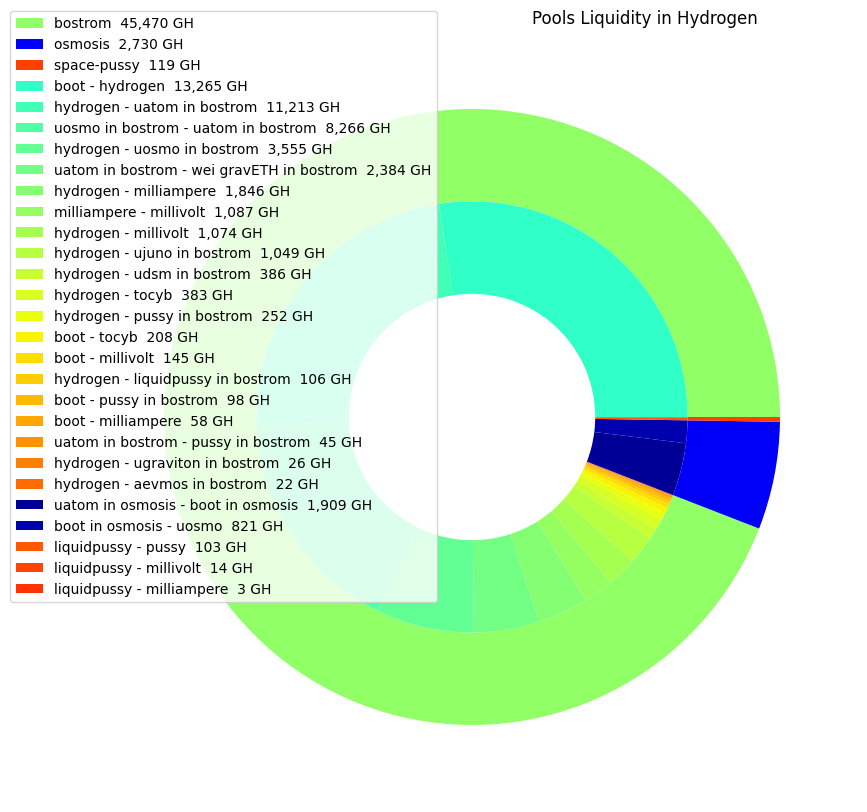

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(
            price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[((pools_df.network != 'osmosis') | (pools_df.id != 1)) & \
             ((pools_df.network != 'space-pussy') | (pools_df.id != 3))][
        ['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(
    f"Total liquidity: {round(sum(pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)]['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cm2 = plt.get_cmap("jet", 50)
cout = cm(np.array([10, 2, 16]))


pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = pools_df[pools_df['liquidity, GH'] > 1].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm2(np.array(list(range(20, 40)) + list(range(1, 3)) + list(range(40, 47))))
ax.pie(inner.values.flatten(),
       radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.1, 0.26))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,liquidity,"liquidity, GH"
hydrogen,bostrom,1.658894e+13,1.658894e+13
uatom in bostrom,bostrom,3.375973e+09,1.096396e+13
boot,bostrom,2.446977e+12,6.887719e+12
uosmo in bostrom,bostrom,2.531012e+10,5.910477e+12
milliampere,bostrom,3.912938e+08,1.524570e+12
boot in osmosis,osmosis,4.838722e+11,1.361997e+12
millivolt,bostrom,3.247756e+07,1.152595e+12
uatom in osmosis,osmosis,2.939569e+08,9.546677e+11
ujuno in bostrom,bostrom,1.498336e+09,5.246104e+11
uosmo,osmosis,1.755059e+09,4.098452e+11


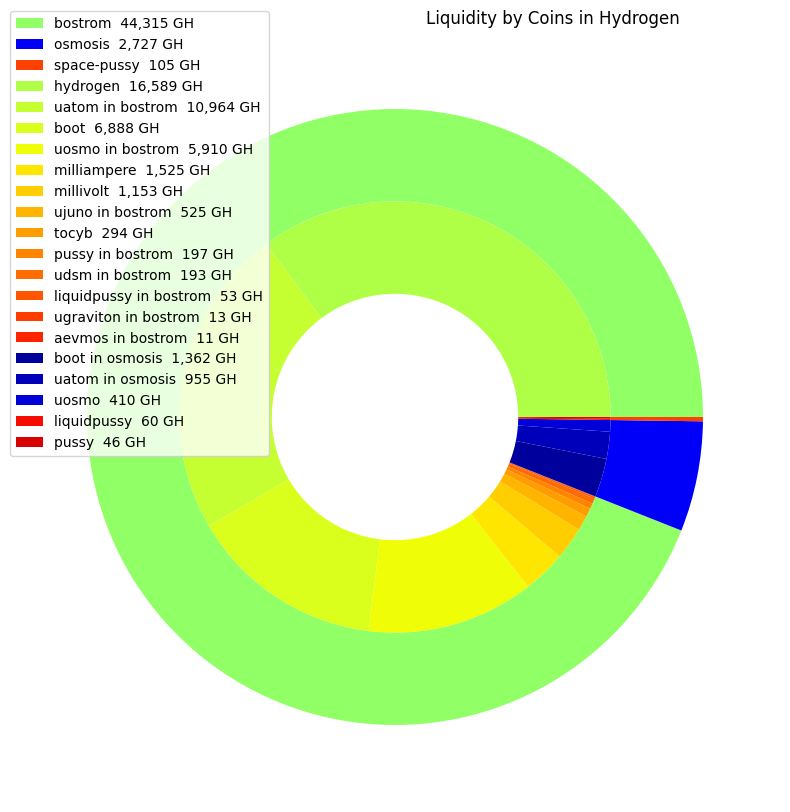

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
print('Liquidity by Coins')
for coin_denom in coin_list:
    if coin_denom in ('milliampere', 'millivolt'):
        pools_df.loc[:, f'{coin_denom}_balance'] = pools_df[pools_df.network != 'space-pussy'].balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin_denom=coin_denom))
    else:
        pools_df.loc[:, f'{coin_denom}_balance'] = pools_df.balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin_denom=coin_denom))
    if coin_denom == 'uosmo' or coin_denom[-7:] == 'osmosis':
        network = 'osmosis'
    elif coin_denom[-5:] == 'pussy':
        network = 'space-pussy'
    else:
        network = 'bostrom'
    coin_liquidity_data.append({
        'coin': coin_denom,
        'network': network,
        'liquidity': pools_df[f"{coin_denom}_balance"].sum(),
        'liquidity, GH': pools_df[f"{coin_denom}_balance"].sum() * price_enriched_df.loc['hydrogen', coin_denom]})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.array([10, 2, 16]))

outer = coin_liquidity_df.groupby('network')[
    'liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False) / 1e9
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[True],
                                                                                             inplace=False) / 1e9
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cm2 = plt.get_cmap("jet", 40)
cin = cm2(np.array(list(range(22, 35)) + list(range(1, 4)) + list(range(35, 40))))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(0, 0.45))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')